### 线性回归
#### 有监督模型
x1+x2->y
x1q1+x2q2+q3=y
x:数据，特征
y:便签
$$\sum \theta_{i} x_{i}=\theta^{\top} x$$

### 决策树
- 分类+回归
- 根节点选择（信息增益），越分越细
- 控制决策树高度（剪枝）

In [1]:
import pandas as pd
iris = pd.read_csv('iris.data')
iris.head()

,4.9,3.0,1.4,0.2,Iris-setosa
0,4.7,3.2,1.3,0.2,Iris-setosa
1,4.6,3.1,1.5,0.2,Iris-setosa
2,5.0,3.6,1.4,0.2,Iris-setosa
3,5.4,3.9,1.7,0.4,Iris-setosa
4,4.6,3.4,1.4,0.3,Iris-setosa


In [2]:
iris.columns = ['sepal_length_cm','s_width_cm','petal_length_cm','p_width_cm','class']
iris.head()

,sepal_length_cm,s_width_cm,petal_length_cm,p_width_cm,class
0,4.7,3.2,1.3,0.2,Iris-setosa
1,4.6,3.1,1.5,0.2,Iris-setosa
2,5.0,3.6,1.4,0.2,Iris-setosa
3,5.4,3.9,1.7,0.4,Iris-setosa
4,4.6,3.4,1.4,0.3,Iris-setosa


In [3]:
iris.describe()

,sepal_length_cm,s_width_cm,petal_length_cm,p_width_cm
count,148.000000,148.000000,148.000000,148.000000
mean,5.854730,3.051351,3.790541,1.212162
std,0.827695,0.434950,1.754657,0.759332
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.400000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


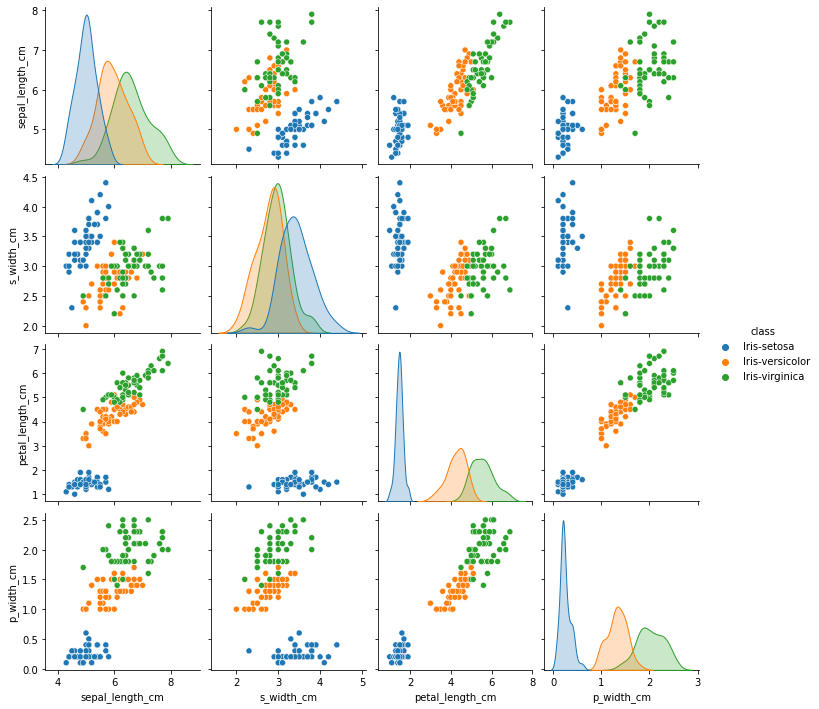

In [4]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.pairplot(iris.dropna(),hue = 'class')

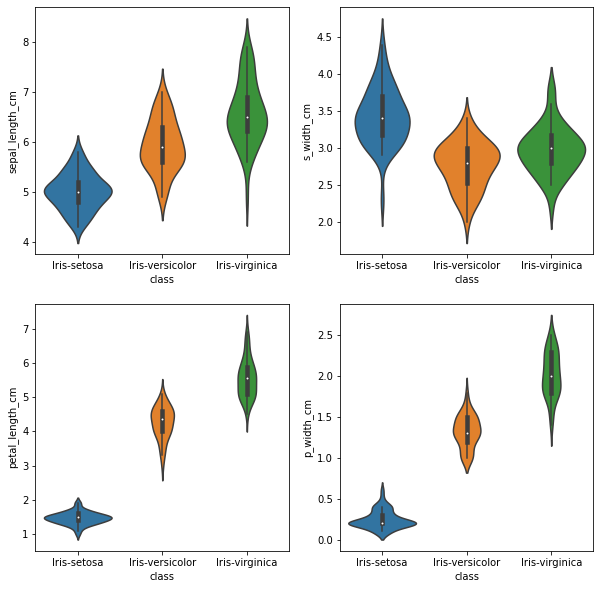

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.figure(figsize=(10,10))
for column_index,column in enumerate(iris.columns):
    if column == 'class':
        continue
    plt.subplot(2,2,column_index+1)
    sb.violinplot(x= 'class', y=column, data = iris)

In [6]:
from sklearn.tree import DecisionTreeClassifier

### 贝叶斯算法
  $$ P(A|B)=P(B|A)*P(A)/P(B)$$

In [7]:
#贝叶斯拼写检查器
#P(h|D)=P(D|h)*P(h)/P(D)

import pandas as pd
import numpy as np
import re,collections
fr=open('byes.txt').read()
def words(text): return re.findall('[a-z]+',text.lower())#把文章中所有的单词取出来，转化成小写，并去除单词中的特殊符号
def train(features):
    model = collections.defaultdict(lambda: 1) #所训练的数据集中有可能有包含不到的词，而这些词也是正确的，所以设置lambda：1，让每个词出现的次数默认为1
    for f in features:
        model[f] += 1
    return model
NWORDS = train(words(fr))
alphabet = 'abcdefghijklmnopqrstuvwxyz'
def edits1(word):
    n = len(word)
    return set([word[0:i]+word[i+1:] for i in range(n)] +                     # 少一个字母的情况
    [word[0:i]+word[i+1]+word[i]+word[i+2:] for i in range(n-1)] + # 字母调换的情况
    [word[0:i]+c+word[i+1:] for i in range(n) for c in alphabet] + # 修改字母情况
    [word[0:i]+c+word[i:] for i in range(n+1) for c in alphabet])  # 插入字母的情况
def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in NWORDS)
def known(words): return set(w for w in words if w in NWORDS)
def correct(word):
    candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
    return max(candidates, key=lambda w: NWORDS[w])



### 支持向量机 SVM
- 决策边界越胖越好(最大化间隔，平行线插到的向量叫支持向量)
$$ y_{i}\left(\mu^{\top} x_{i}+b\right) \leqslant 0$$
（公式1）
- 转换为使||μ||²最小化（限制条件，公式1>=1）


#### SVM处理非线性问题
- 最小化维度越高线性可分概率越大，维度无限大，概率为1
- 低维不可分，高维可分
- 核函数

In [8]:
"""
    Author: Lasse Regin Nielsen
"""
import os
import sys
import csv
import numpy as np
import random as rnd
filepath = os.path.dirname(os.path.abspath(__file__))

class SVM():
    """
        Simple implementation of a Support Vector Machine using the
        Sequential Minimal Optimization (SMO) algorithm for training.
    """
    def __init__(self, max_iter=10000, kernel_type='linear', C=1.0, epsilon=0.001):
        self.kernels = {
            'linear' : self.kernel_linear,
            'quadratic' : self.kernel_quadratic
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon
    def fit(self, X, y):
        # Initialization
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            # Check convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break

            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
        # Compute final model parameters
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)
        # Get support vectors
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]
        return support_vectors, count
    def predict(self, X):
        return self.h(X, self.w, self.b)
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))
    # Prediction
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    # Prediction error
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i
    # Define kernels
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)
def readData(filename, header=True):
    data, header = [], None
    with open(filename, 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        if header:
            header = spamreader.next()
        for row in spamreader:
            data.append(row)
    return (np.array(data), np.array(header))

def calc_acc(y, y_hat):
    idx = np.where(y_hat == 1)
    TP = np.sum(y_hat[idx] == y[idx])
    idx = np.where(y_hat == -1)
    TN = np.sum(y_hat[idx] == y[idx])
    return float(TP + TN)/len(y)

def main(filename='data/iris-virginica.txt', C=1.0, kernel_type='linear', epsilon=0.001):
    # Load data
    (data, _) = readData('%s/%s' % (filepath, filename), header=False)
    data = data.astype(float)

    # Split data
    X, y = data[:,0:-1], data[:,-1].astype(int)

    # Initialize model
    model = SVM()

    # Fit model
    support_vectors, iterations = model.fit(X, y)

    # Support vector count
    sv_count = support_vectors.shape[0]

    # Make prediction
    y_hat = model.predict(X)

    # Calculate accuracy
    acc = calc_acc(y, y_hat)

    print("Support vector count: %d" % (sv_count))
    print("bias:\t\t%.3f" % (model.b))
    print("w:\t\t" + str(model.w))
    print("accuracy:\t%.3f" % (acc))
    print("Converged after %d iterations" % (iterations))

if __name__ == '__main__':
    if ('--help' in sys.argv) or ('-h' in sys.argv):
        print("")
        print("Trains a support vector machine.")
        print("Usage: %s FILENAME C kernel eps" % (sys.argv[0]))
        print("")
        print("FILENAME: Relative path of data file.")
        print("C:        Value of regularization parameter C.")
        print("kernel:   Kernel type to use in training.")
        print("          'linear' use linear kernel function.")
        print("          'quadratic' use quadratic kernel function.")
        print("eps:      Convergence value.")
    else:
        kwargs = {}
        if len(sys.argv) > 1:
            kwargs['filename'] = sys.argv[1]
        if len(sys.argv) > 2:
            kwargs['C'] = float(sys.argv[2])
        if len(sys.argv) > 3:
            kwargs['kernel_type'] = sys.argv[3]
        if len(sys.argv) > 4:
            kwargs['epsilon'] = float(sys.argv[4])
        if len(sys.argv) > 5:
            sys.exit("Not correct arguments provided. Use %s -h for more information"% (sys.argv[0]))
        main(**kwargs)


NameError: name '__file__' is not defined

### 神经网络

- K近邻（无需训练）
- 线性分类
- 损失函数（正则化惩罚项，惩罚参数）
- softmax分类器（sigmoid函数）
-      
-                                                                                                     

### 降维和度量学习
- MDS 算法
- PCA降维
- SVD分解
- 

### 特征选择和稀疏学习
- EM算法
- NP难问题
- SVM TSVM

### 强化学习

$$ \begin{array}{l}
\pi\left(s_{t}, a_{r}\right)=P\left(a_{t} \mid s_{t}\right)
\end{array}$$
$$ 
V^{\pi}(s)=\mathbb{E}\left[\sum_{t \geq 0} \gamma^{t} r_{t} \mid s_{0}=s, \pi\right]
$$
$$
Q^{\pi}(s, a)=\mathbb{E}\left[\sum_{t \geq 0} \gamma^{t} r_{t}\mid s_{0}=s, a_{0}=a, \pi\right]
$$
#### Q-learning
$$
\begin{aligned}
\mathrm{V}^{\pi}(s) &=E_{\pi}\left[\sum_{t=0}^{+\infty} \gamma^{t} r_{t} \mid S_{0}=S, \pi\right] \\
=& E_{\pi}\left[r_{0}+\sum_{t=0}^{+\infty} \gamma^{t} r_{t+1} \mid S_{0}=S, \pi\right] \\
=& \sum_{a \in A} \pi(S, a) \sum_{S^{\prime} \in S} P_{S S^{\prime}}^{a}\left(R_{S}^{a}+\gamma V^{\pi}\left(S^{\prime}\right)\right) \\
& \text { 其中 } \pi(S, a)=p(a \mid S) \\
Q^{\pi}(s, a)=& \sum_{S^{\prime} \in S} P_{S S^{\prime}}^{a}\left(R_{S}^{a}+\gamma V^{\pi}\left(S^{\prime}\right)\right) \\
\pi(S, a)=&\left\{\begin{array}{l}
1: \text { 若 } a=\operatorname{argmax} Q(S, a) \\
0: \text { 其他 }
\end{array}\right.\\
\text { 则有 }  \\
\mathrm{V}^{\pi}(s)=\sum_{a \in A} \pi(S, a) Q^{\pi}(s, a)
\end{aligned}
$$

### 高斯混合模型 EM算法


### 回归模型